# Computer Vision - Assignment 1 - Convolution and Derivatives

#### 10 (+3) points   |   Due date: October 28, 23:59   |   Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: JESÚS MIGUEL ROJAS GÓMEZ

The goal of this assignment is to learn how to use OpenCV to implement convolution-based image filtering techniques. 


---


## Normas de entrega

Para este trabajo, al igual que para los demás, se deben presentar  las valoraciones y decisiones adoptadas en cada uno de los apartados. También deberá incluirse una valoración sobre la calidad de los resultados obtenidos. Se recuerda que código sin informe explicativo no puntúa.

Este trabajo de implementación tiene como objetivo principal aprender a implementar filtros de convolución y, particularmente, el cálculo de las derivadas de una imagen. El documento pdf sobre Gaussian discretization disponible en PRADO (https://pradogrado2223.ugr.es/pluginfile.php/209014/mod_folder/content/0/Bibliografia/Gaussian_discretization.pdf) puede resultar de gran utilidad para la implementación del ejercicio 1.A.

Normas de entrega (EL INCUMPLIMIENTO DE ESTAS NORMAS SIGNIFICA PÉRDIDA DIRECTA DE 1 PUNTO CADA VEZ QUE SE DETECTE UN INCUMPLIMIENTO):

1. El diseño de celdas del documento debe ser respetado.
2. Solo se entregará el código fuente (fichero .ipynb) y no se enviarán las imágenes empleadas.
3. Los path que se usen en la lectura de imágenes o cualquier otro fichero de entrada debe ser siempre “/content/drive/My Drive/images/nombre_fichero”
4. El código deberá  presentarse con los resultados obtenidos en cada apartado junto con los  correspondientes comentarios y valoraciones.  Recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.

---

In [57]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive')
# change directory
%cd '/content/drive/MyDrive'
#  the current directory
%pwd
import os
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/MyDrive/images', route)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [58]:
import sys,os
# Let's import the python module P0. 
# You must create the directory CV and put inside the file P0.py
# P0.py is the module created from your notebook P0.
path_to_module='/content/drive/My Drive/CV/'
sys.path.append(os.path.abspath(path_to_module))

import P0

In [59]:
# We import the modules to use
import cv2, numpy as np, math
from matplotlib import pyplot as plt
# This allows to display images  and to save  them in cells
%matplotlib inline

# **Exercise-1**: Write Python code to implement the following tasks efficiently (4 points). 




## A)

Compute discrete masks of the 1D Gaussian and its normalized first and second derivatives. Consider both the size of the mask and the sigma value as possible inputs. Use the sigma values {1, 2.3, 3.7,5} and size masks {7,11,15} as inputs, and draw the mask values as 1D graphs using matplotlib. (1.5 points)

Definimos una función `gaussianMask1D`, que, dados como argumento el valor de sigma, `sigma`, el tamaño de la máscara, `sizeMask`, y el orden, `order`, calcula la máscara Gaussiana de orden `order`. Para este apartado hemos considerado que en caso de aportar tanto el valor de `sigma` como el valor de `sizeMask`, usaremos el valor de `sigma` para realizar los cálculos. Para resolver el ejercicio, en primer lugar, cálculamos el valor de `k` y creamos el vector de coordenadas de longitud `k` centrado en 0 (`x`). Una vez definido esto, calculamos la máscara Gaussiana.

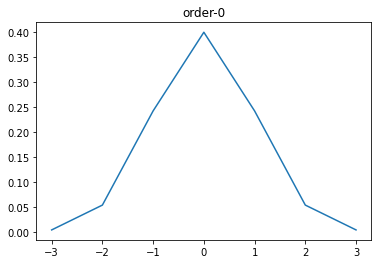

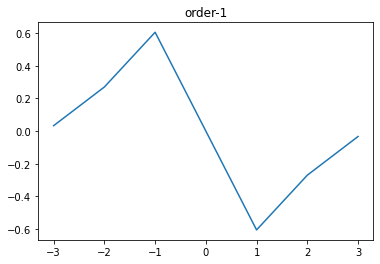

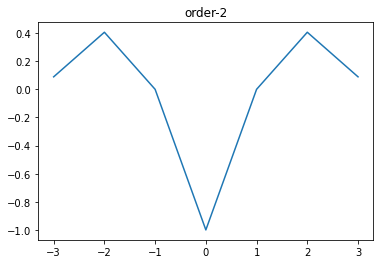

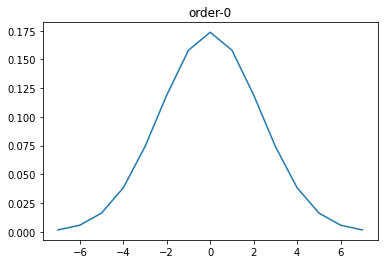

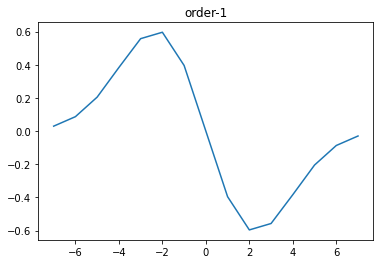

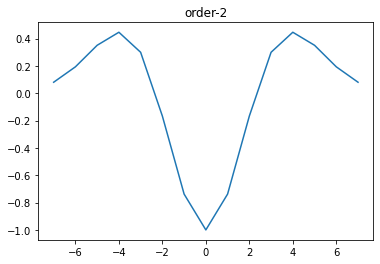

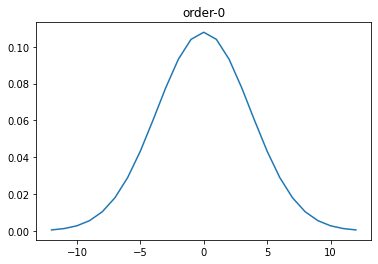

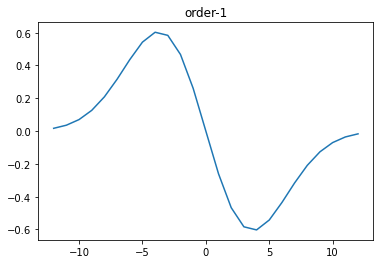

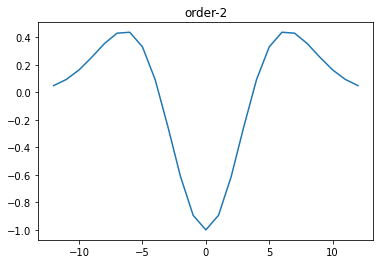

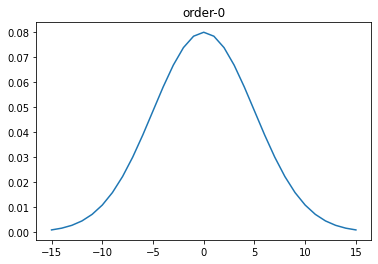

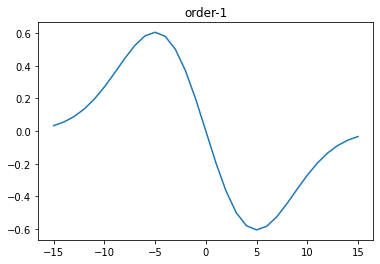

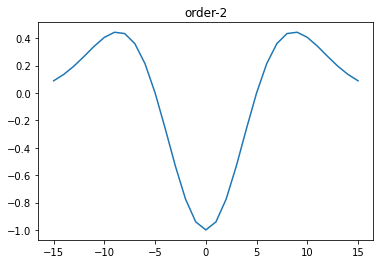

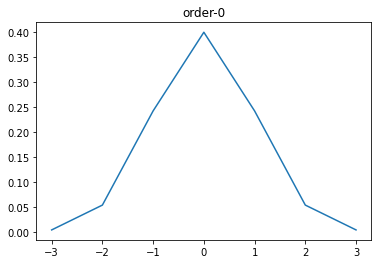

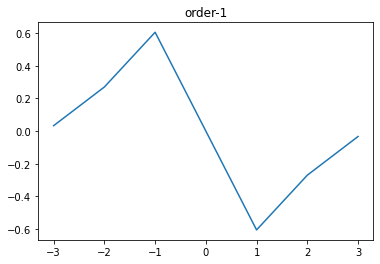

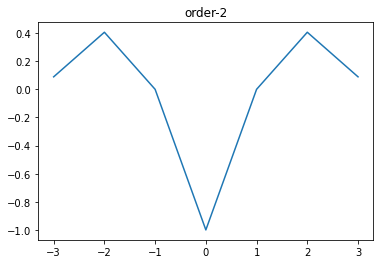

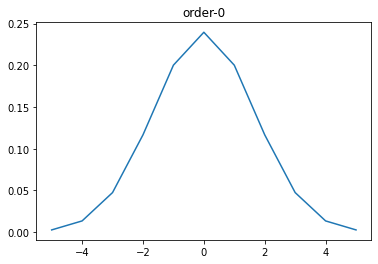

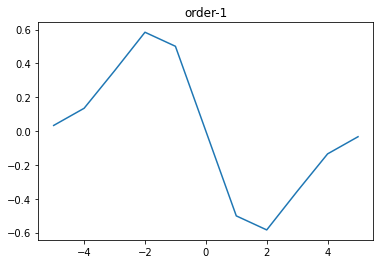

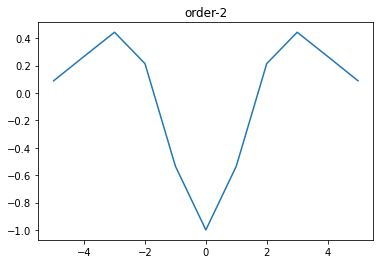

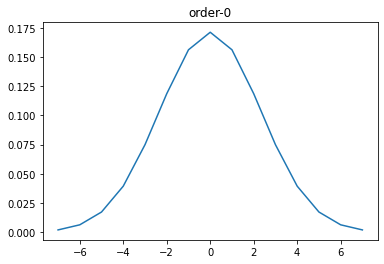

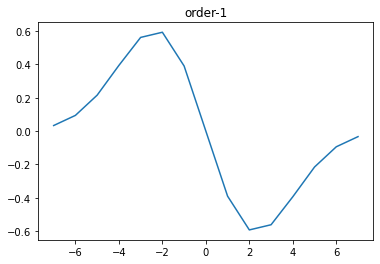

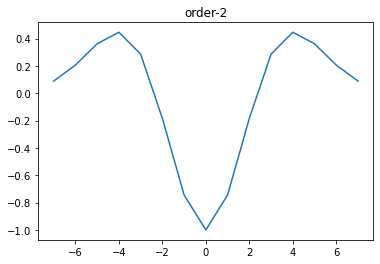

In [60]:
def gaussianMask1D(sigma=0, sizeMask=0, order=0):
  if sigma != 0:
    sizeMask = int(6*sigma)+1
  elif sizeMask != 0:
      sigma = (sizeMask-1)/6

  # elegimos k tal que k sea el entero más pequeño que cumple k >= 3*sigma
  # si sigma = 1, k = 3, pero si sigma = 1.1, 3*sigma = 3.3 -> k = 4 
  k = np.ceil(3*sigma)
  x = np.arange(-k, k+1, 1, dtype=np.int_)

  mask = pow(np.e, (-0.5*x**2)/(sigma**2))  
  if order == 0:
    mask = mask/np.sum(mask) # tiene que sumar 1, por lo que normalizamos
  elif order == 1:
    mask = -x/sigma*mask
  elif order == 2:
    mask = (x**2/sigma**2-1)*mask

  return mask

def plotGraph(graph, title='No title'):
  k = (len(graph)-1)/2
  plt.plot(np.arange(-k,k+1,1,dtype=np.int_),graph)
  plt.title(title)
  plt.show()

# Let's check the functions
# You must experiment with different values for sigma and sizeMask
# Write down your conclusions 
# Dibujamos con los valores proporcionados en el enunciado
sigma = [1, 2.3, 3.7, 5]
sizeMask = 0
for elem in sigma:
  plotGraph(gaussianMask1D(elem, sizeMask, order=0), title='order-0')
  plotGraph(gaussianMask1D(elem, sizeMask, order=1), title='order-1')
  plotGraph(gaussianMask1D(elem, sizeMask, order=2), title='order-2')

sigma = 0
sizeMask = [7, 11, 15]
for elem in sizeMask:
  plotGraph(gaussianMask1D(sigma, elem, order=0), title='order-0')
  plotGraph(gaussianMask1D(sigma, elem, order=1), title='order-1')
  plotGraph(gaussianMask1D(sigma, elem, order=2), title='order-2')

## CONCLUSIONES

Podemos comprobar en las gráficas que cuanto mayor es el valor de `sigma` y mayor es el valor de `sizeMask` la gráfica de la función aparece "más suavizada", es decir, con "menos picos". 

(Por alguna extraña razón la suma de las derivadas no da exactamente 0.0. He ido comprobando valor por valor la máscara viendo que valores tenía con print y su suma si debería dar 0 porque los valores son los mismos pero con signo cambiado, pero por alguna razón que no sé no da 0.0).

## B)




Read an image in gray level. Smooth it applying the convolution with masks defined by a set of increasing sigma values, i.e. sigma= 0.8,1.5,3,6,12. Display all smoothed images in the same canvas. Use the OpenCV’s function `sepFilter2D()` with masks computed using your functions from (A). (1.5 points)

Para resolver este apartado definiremos una función `my2DConv` que dados una imagen `im`, el valor de `sigma` y un vector de dos componentes `orders` que indica el orden, realiza una convolución 2D a `im`, aplicando en el eje X una máscara Gaussiana de valor de sigma `sigma` y orden `orders[0]` y en el eje Y una máscara Gaussiana con el mismo valor de sigma y orden `orders[1]`. Para ello, nos apoyaremos en la función `sepFilter2D`.  

In [61]:
# orders es un vector de dos valores [filas,columnas]
def my2DConv(im, sigma, orders):
  # A partir de estos ordenes podemos obtener el resto
  if orders == [0,0]:
    return cv2.sepFilter2D(src=im, ddepth=-1, kernelX=gaussianMask1D(sigma, sizeMask=0, order=0), kernelY=gaussianMask1D(sigma, sizeMask=0, order=0))
  elif orders == [1,0]:
    return cv2.sepFilter2D(src=im, ddepth=-1, kernelX=gaussianMask1D(sigma, sizeMask=0, order=1), kernelY=gaussianMask1D(sigma, sizeMask=0, order=0))
  elif orders == [0,1]:
    return cv2.sepFilter2D(src=im, ddepth=-1, kernelX=gaussianMask1D(sigma, sizeMask=0, order=0), kernelY=gaussianMask1D(sigma, sizeMask=0, order=1))
  elif orders == [2,0]:
    return cv2.sepFilter2D(src=im, ddepth=-1, kernelX=gaussianMask1D(sigma, sizeMask=0, order=2), kernelY=gaussianMask1D(sigma, sizeMask=0, order=0))
  elif orders == [0,2]:
    return cv2.sepFilter2D(src=im, ddepth=-1, kernelX=gaussianMask1D(sigma, sizeMask=0, order=0), kernelY=gaussianMask1D(sigma, sizeMask=0, order=2))
  else:
    ('error in order of derivative')

im=cv2.imread(get_image('zebra.jpg'),0).astype(np.float64)

vim0=[]
orders = [0,0]
for sigma in [0.8,1.5,3,6,12]:
  vim0.append(P0.rangeDisplay01(my2DConv(im,sigma,orders),False))

orders = [1,0]
vim1=[]
for sigma in [0.8,1.5,3,6,12]:
  vim1.append(P0.rangeDisplay01(my2DConv(im,sigma,orders),False))

orders = [0,1]
vim1y = []
for sigma in [0.8,1.5,3,6,12]:
  vim1y.append(P0.rangeDisplay01(my2DConv(im,sigma,orders),False))

orders = [2,0]
vim2=[]
for sigma in [0.8,1.5,3,6,12]:
  vim2.append(P0.rangeDisplay01(my2DConv(im,sigma,orders),False))

orders = [0,2]
vim2y=[]
for sigma in [0.8,1.5,3,6,12]:
  vim2y.append(P0.rangeDisplay01(my2DConv(im,sigma,orders),False))

vimL=[]
for sigma in [0.8,1.5,3,6,12]:
  vimL.append(P0.rangeDisplay01(sigma**2*(my2DConv(im,sigma,[2,0])+my2DConv(im,sigma,[0,2])),False))

P0.displayMI_ES(vim0, 'Zero derivative', factor=5)
P0.displayMI_ES(vim1, 'First derivative-x', factor=5)
P0.displayMI_ES(vim1y, 'First derivative-y', factor=5)
P0.displayMI_ES(vim2, 'Second derivative-x', factor=5)
P0.displayMI_ES(vim2y, 'Second derivative-y', factor=5)
P0.displayMI_ES(vimL, 'Laplacian', factor=5)

Output hidden; open in https://colab.research.google.com to view.

Podemos apreciar en las imágenes que, si realizamos una convolución 2D de orden `[0,0]` aplica un suavizado a la imagen, si realizamos una de orden `[x,0]` con `x=1,2` la imagen resultante resalta las líneas verticales, y si realizamos una de orden `[0,y]` con `y=1,2` resalta las líneas horizontales. Por otro lado, la laplaciana detecta los bordes tanto horizontales como verticales.

Además, cuanto mayor es el valor de `sigma`, este efecto se aprecia bastante más debido a que el tamaño de la máscara es mayor.

## C)	

Use the OpenCV’s function `sepFilter2D()` to compute the gradient and Laplacian images using your masks from (A). Display all results in the same canvas. (1 point)

Definimos las funciones `gradientIM` y `laplacianG`, que dada una imagen `im` y el valor de sigma `sigma` calcula el gradiente de la imagen y la laplaciana de la imagen respectivamente. Con estas funciones podemos calcular lo que nos pide el ejercicio. Concretamente, usaremos las fórmulas siguientes: $$mag = sqrt(G_x^2 + G_y^2)$$ $$orient = atan2(G_y,G_x)$$ $$laplaciana = σ^2 (G_{xx}+G_{yy})$$ donde $G_x$ indica la primera derivada horizontal, $G_y$ indica la primera derivada vertical, y $G_{xx}$ y $G_{yy}$ indica la segunda derivada horizontal y vertical respectivamente.

(Este ejercicio dice que mostremos las imagenes en el mismo lienzo, pero apoyándome en lo que he hecho en la P0 no se muestran bien. Como en esta práctica en teoria no se evalúa como se muestran las imágenes, lo he mostrado separado para que se aprecie mejor el resultado)

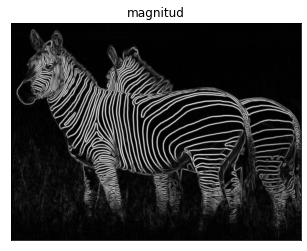

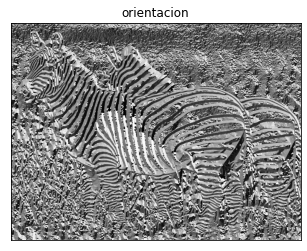

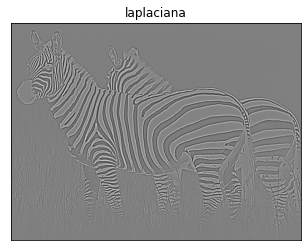

In [62]:
def gradientIM(im,sigma):
  dx = my2DConv(im,sigma,[1,0])
  dy = my2DConv(im,sigma,[0,1])

  return dx,dy

def laplacianG(im,sigma):
  return sigma**2*(my2DConv(im,sigma,[2,0])+my2DConv(im,sigma,[0,2])) 
  

sigma = 3
image = cv2.imread(get_image('zebra.jpg'),0)
#
# The computation must be done in floating point !!!
im = np.array(image,np.float64)
#
dx,dy = gradientIM(im,sigma)
mag = np.sqrt(dx**2+dy**2)
orient = np.arctan2(dy,dx)

P0.displayIm(mag,'magnitud')
P0.displayIm(orient,'orientacion')
P0.displayIm(laplacianG(im,sigma),'laplaciana')


Podemos comprobar en las imágenes mostradas que tanto la magnitud como la laplaciana resaltan los bordes de la imagen, y restante se muestra la orientación del gradiente de la imagen.

# **Exercise-2**:  Using your functions from  previous exercises, write Python functions and show results for the following tasks (6 points).





## A) 

Build up a 4-level Gaussian pyramid for an image using Gaussian masks of size 7x7.  Display all levels  in the same canvas.  (2 points)

En primer lugar definimos una función `displayPyramid` que, dado un vector de imágenes `pyrG` muestra en el mismo lienzo estas imágenes. Hay que tener en cuenta que `pyrG[i]` tiene el doble de tamaño que `pyrG[i+1]`. Sabiendo esto, colocamos la primera imagen, la imagen más grande, arriba a la izquierda. Colocamos la siguiente imagen a la derecha de la primera, y las siguientes imágenes las vamos colocando una tras otra debajo de la segunda hasta haberlas incluido todas. Como las imágenes tienen cada vez la mitad del tamaño, vamos completando con ceros para poder mostrar bien el lienzo.

In [63]:
def displayPyramid(pyrG, title=''):
  bn = True
  if len(pyrG[0].shape) == 3:
    bn = False 

  listh = [] # listh contendrá la primera imagen (la más grande) y el resto de imágenes unidas verticalmente
  listv = [] # listv contendrá todas las imágenes menos la primera unidas verticalmente
  listh.append(pyrG[0])

  listv.append(pyrG[1])
  i = 2
  while i < len(pyrG):
    aux = pyrG[i]
    aux = np.hstack([aux,np.zeros((aux.shape[0],listv[0].shape[1]-aux.shape[1]))]) if bn else np.hstack([aux,np.zeros((aux.shape[0],listv[0].shape[1]-aux.shape[1],3))])
    listv.append(aux)
    i = i + 1 
    
  sum = np.sum([elem.shape[0] for elem in listv])

  listv.append(np.zeros((listh[0].shape[0]-sum,listv[0].shape[1]))) if bn else listv.append(np.zeros((listh[0].shape[0]-sum,listv[0].shape[1],3)))
  aux = np.vstack(listv)
  listh.append(aux)
  im = np.hstack(listh)

  P0.displayIm(im,title,factor=2)

Definimos ahora la función `pyramidGauss` que dada una imagen `im`, el tamaño de la máscara `sizeMask` y el nivel de profundidad `nlevel` calcula la piràmide Gaussiana de profundidad `nlevel`. Para ello, en cada iteración aplica un alisamiento a la imagen obtenida y reduce su tamaño a la mitad. Para reducir el tamaño, el criterio que he seguido es el de eliminar filas y columnas impares.

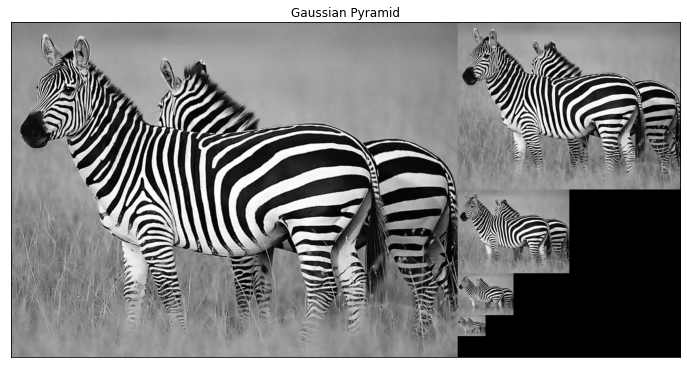

In [64]:
def pyramidGauss(im, sizeMask=7, nlevel=4):
  vim = [im]
  sigma = (sizeMask-1)/6

  for i in range(nlevel):
    # aplicamos el alisamiento
    aux = my2DConv(vim[i],sigma,[0,0])
    rows = []
    for j in range(aux.shape[0]):
      if j%2 == 1:
        rows.append(j)
    # eliminamos filas
    imlevel = np.delete(aux,rows,0)
    cols = []
    aux = imlevel
    for j in range(aux.shape[1]):
      if j%2 == 1:
        cols.append(j)
    # eliminamos columnas
    imlevel = np.delete(aux,cols,1)
    # añadimos la imagen a la pirámide
    vim.append(imlevel)
  
  return vim

im = cv2.imread(get_image('zebra.jpg'),0).astype(np.float64)
pyrG = pyramidGauss(im,sizeMask=7, nlevel=4)
displayPyramid(pyrG,'Gaussian Pyramid')

## B)

Using your code from A), implement a function to build a 4-level Laplacian pyramid.  The type of interpolation employed is now relevant. Show two examples using the images provided. Show all levels on the same canvas. (2 points) 

Definimos ahora `pyramidLap`, que dada una imagen `im`, el tamaño de la máscara `sizeMask`, el nivel de profundidad `nlevel` y el flag de interpolación `flagInterp` calcula la piramide Laplaciana. Para ello, calculamos primero la pirámide Gaussiana, y calculamos la diferencia entre la imagen de la pirámide Gaussiana y la siguiente en la pirámide, habiendole aplicado a esta ultima un resize con el flag de interpolación pasado como argumento.

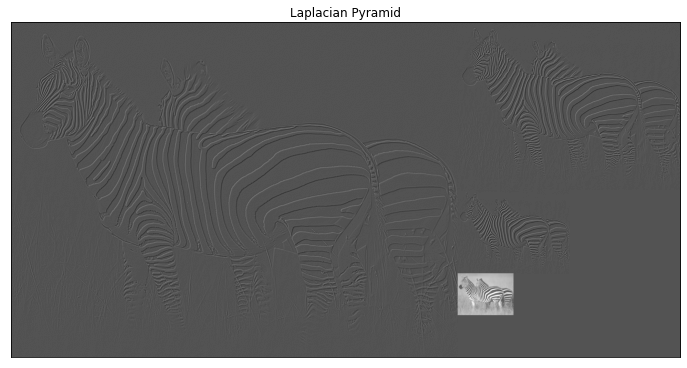

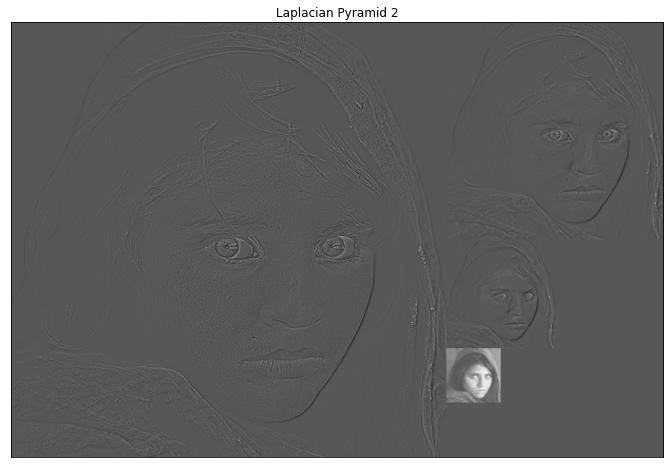

In [65]:
def pyramidLap(im, sizeMask,nlevel=4,flagInterp=cv2.INTER_LINEAR):
  vimG = pyramidGauss(im,sizeMask,nlevel)

  vimL = []
  for i in range(nlevel-1):
    # resize a la siguiente imagen con el flag pasado como argumento
    aux = cv2.resize(vimG[i+1],(vimG[i].shape[1],vimG[i].shape[0]),1,1,flagInterp)
    # calculamos la diferencia
    vimL.append(vimG[i]-aux)  
  vimL.append(vimG[nlevel-1])

  return vimL

im=cv2.imread(get_image('zebra.jpg'),0).astype(np.float64)
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)
displayPyramid(pyrL,'Laplacian Pyramid')
im2 = cv2.imread(get_image('india.jpeg'),0).astype(np.float64)
pyrL2 = pyramidLap(im2,sizeMask=7, nlevel=4)
displayPyramid(pyrL2,'Laplacian Pyramid 2')

## C) 

Implement a function to reconstruct the image encoded in the Laplacian pyramid. Take one of the pyramids from B) and verify that it is possible to obtain an exact copy of the original image. To do this, calculate the Frobenius norm of the difference between the original and the reconstructed images.(2 points)

Para ello, definimos la función `reconstructIm` que dada una pirámide Laplaciana `pyL` y el flag de interpolación usado `flagInterp` reconstruye la imagen original. En primer lugar, ordenamos de menor a mayor la piramide Laplaciana. Para obtener la imagen original, en cada iteración, realizamos la suma entre la siguiente imagen de la pirámide y la imagen actual, habiendole aplicado a esta ultima un resize con el flag de interpolación dado como argumento. Por último, calculamos la norma de Frobenius para ver que no hay diferencia con la imagen original (el error es 0.0). Hay que destacar que los flags de interpolación al reconstruir la imagen y al construir la pirámide laplaciana deben ser el mismo.

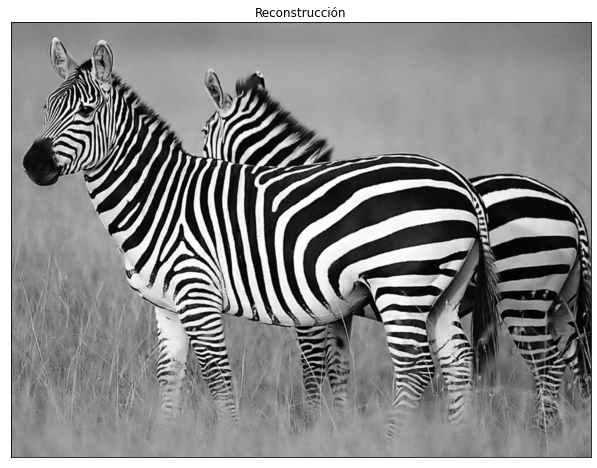

Error per pixel 1.5074235678075695e-13


In [66]:
def reconstructIm(pyL,flagInterp):
  # ordenamos de menor a mayor las imágenes
  pyLo = []
  for i in range(len(pyL)):
    pyLo.append(pyL[len(pyL)-i-1])

  im = pyLo[0]
  for i in range(len(pyLo)-1):
    # resize a la siguiente imagen con el flag de interpolacion
    aux = cv2.resize(im,(pyLo[i+1].shape[1],pyLo[i+1].shape[0]),1,1,flagInterp)
    # calculamos la suma
    im = aux + pyLo[i+1]

  return im

im=cv2.imread(get_image('zebra.jpg'),0)
im = np.array(im,np.float64) # hay que hacer las operaciones en coma flotante para comprobar el error
pyrL = pyramidLap(im,sizeMask=7, nlevel=4, flagInterp=cv2.INTER_LINEAR)
recons=reconstructIm(pyrL,flagInterp=cv2.INTER_LINEAR)
P0.displayIm(recons,'Reconstrucción',2)
# norma de Frobenius
print('Error per pixel',np.sqrt(np.linalg.norm(im-recons, ord=2))/np.prod(im.shape))
# The final error must be 0.0

(Soy consciente de que el error no da 0.0, a mi me da un número elevado a menos trece que es prácticamente 0.0. De nuevo, por alguna extraña razón, el error no da exacto (puede ser por los valores de la máscara como comento más arriba o no lo sé). En todo momento leo las imágenes en coma flotante y uso el mismo flag de interpolación, por lo que debería ser 0.0)

# **BONUS: HYBRID IMAGES** (3 points)

This bonus section is based on the following paper about hybrid imaging: SIGGRAPH 2006 paper by Oliva, Torralba, and Schyns (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf).  

 The goal of this bonus is to learn how the human visual system extracts information about an object depending on the distance. To do this, we construct a hybrid image from two images of different objects. By appropriately mixing part of the high frequencies of one image with part of the low frequencies of another image, we obtain a hybrid image that shows different perceptions with distance.  The smoothing of both images is the key aspect to select the high and low frequency range of each image.  The higher the sigma value, the greater the removal of high frequencies from the image. It is recommendable to choose this value separately for each of the images (see recommendations given in the article by Oliva et al.) and, in fact, more than one value may be possible. Steps to follow: 
 
1. Read the paper. 

2. Find the appropriate sigma values for each pair of images. Extract the low and high frequency images and calculate the hybrid image as the average of them. (Hint: the low frequencies must be really low).

3. Test at least two pairs of the provided ones. (Hint: Try gray level images first).

4. Use your visualization functions to display the Gaussian pyramid of the hybrid images. Explain the visual effect perceived. 

En primer lugar, definimos una función `lowIm` que dada una imagen `im` y el valor de sigma `sigma` aplica un filtro de paso bajo a la imagen. En este caso, he elegido un filtro gaussiano. 

Una vez hecho esto, definimos una función `highIm` que dada una imagen `im` y el valor de sigma `sigma` aplica un filtro de paso alto a la imagen. En este caso he elegido la diferencia entre la imagen normal y el resultado de aplicar el filtro de paso bajo a la imagen.

Por ultimo, defino una función `hybridIm` que calcula la imagen hibrida haciendo una media del resultado de aplicar el filtro de paso bajo a la primera imagen `im1` con un valor de sigma `sigma1` y de paso alto a la segunda imagen `im2` con un valor de sigma `sigma2`. En cuanto a los valores de `sigma1` y `sigma2`, para cada par de imágenes los he elegido a base de probar y ver el resultado, teniendo en cuenta que el valor de `sigma2` tiene que ser mayor que el valor de `sigma1`, y teniendo en cuenta que los pares de imágenes con mayor nivel de detalle, y bordes y colores más intensos necesitan mayores valores de sigma. Por ejemplo, en los dos últimos pares de imágenes, los colores son más vivos y los bordes mas notables, por lo que los valores de `sigma1` y `sigma2` son mayores que en los tres primeros pares.

In [67]:
def lowIm(im,sigma):
  return my2DConv(im,sigma,[0,0])

def highIm(im,sigma):
  return im - lowIm(im,sigma)

def hybridIm(im1,im2,sigma1,sigma2):
  return (lowIm(im1,sigma1)+highIm(im2,sigma2))/2


# Primer par de imagenes
im1 = np.array(cv2.imread(get_image('marilyn.bmp'),0),np.float64)
im2 = np.array(cv2.imread(get_image('einstein.bmp'),0),np.float64)
sigma1 = 2
sigma2 = 8
hybrid = hybridIm(im1,im2,sigma1,sigma2)
P0.displayIm(im1, 'Primera imagen', 2)
P0.displayIm(im2, 'Segunda imagen', 2)
displayPyramid(pyramidGauss(hybrid), 'Gaussian Pyramid')

# Segundo par de imagenes
im3 = np.array(cv2.imread(get_image('submarine.bmp'),1),np.float64)
im4 = np.array(cv2.imread(get_image('fish.bmp'),1),np.float64)
sigma1 = 3
sigma2 = 5
hybrid = hybridIm(im3,im4,sigma1,sigma2)
P0.displayIm(im3, 'Primera imagen', 2)
P0.displayIm(im4, 'Segunda imagen', 2)
displayPyramid(pyramidGauss(hybrid), 'Gaussian Pyramid')

# Tercer par de imagenes
im5 = np.array(cv2.imread(get_image('bird.bmp'),1),np.float64)
im6 = np.array(cv2.imread(get_image('plane.bmp'),1),np.float64)
sigma1 = 3
sigma2 = 7
hybrid = hybridIm(im5,im6,sigma1,sigma2)
P0.displayIm(im5, 'Primera imagen', 2)
P0.displayIm(im6, 'Segunda imagen', 2)
displayPyramid(pyramidGauss(hybrid), 'Gaussian Pyramid')

# Cuarto par de imagenes
im7 = np.array(cv2.imread(get_image('dog.bmp'),1),np.float64)
im8 = np.array(cv2.imread(get_image('cat.bmp'),1),np.float64)
sigma1 = 5
sigma2 = 10
hybrid = hybridIm(im7,im8,sigma1,sigma2)
P0.displayIm(im7, 'Primera imagen', 2)
P0.displayIm(im8, 'Segunda imagen', 2)
displayPyramid(pyramidGauss(hybrid), 'Gaussian Pyramid')

# Quinto par de imagenes
im9 = np.array(cv2.imread(get_image('motorcycle.bmp'),1),np.float64)
im10 = np.array(cv2.imread(get_image('bicycle.bmp'),1),np.float64)
sigma1 = 6
sigma2 = 9
hybrid = hybridIm(im10,im9,sigma1,sigma2)
P0.displayIm(im9, 'Primera imagen', 2)
P0.displayIm(im10, 'Segunda imagen', 2)
displayPyramid(pyramidGauss(hybrid), 'Gaussian Pyramid')


Output hidden; open in https://colab.research.google.com to view.

El efecto visual que percibimos es que, en primera instancia, percibimos o podemos apreciar mayoritariamente una imagen, pero conforme avanzamos en la piramide (que modela un efecto similar al de alejarnos de la imagen) podemos apreciar una imagen distinta, como era de esperar según explica el paper.